# Preprocess test audio files of connector mating processes of the Ethernet and HVA 630 connectors (having only one click event during their insertion process) and create labeled datasets using manual labels

This notebook is the implementation of the corresponding part in section ***5.4.1 Dataset*** of the chapter ***5 Experiments*** for creating the test datasets (referred to as **Test Dataset** in the documentation) for the **Ethernet** and **HVA 630** connectors with chunk sizes 32 × 128. More details on the implementation steps can be found in the thesis.

### 1. Import libraries and moduls

In [3]:
# all libraries used in this notebook

import os.path
from pathlib import Path
import re
import librosa
import math
import numpy as np
import matplotlib.pyplot as plt
import sys
import importlib

In [4]:
# import necessary functions from the folder "06_Utilities" for audio file processing and mel-spectrogram plotting

cwd = str(Path.cwd())                                               ## current working directory, should be the path to "01_Dataset", in which this notebook is located
parent_dir = str(Path(cwd).parent)                                  ## parent dir of the current working directory, should be the project directory
utilities_dir_full_path = os.path.join(parent_dir, "06_Utilities")  ## full path to the "05_Utilities" folder

sys.path.append(utilities_dir_full_path)                            ## add the path of the "05_Utilities" folder to the sys.path list

import audioProcessing                                              ## import the modul for audio file processing and mel-spectrogram generation
import spectrogramPlotting                                          ## import the modul for mel-spectrogram visualization
import sharedValues                                                 ## import the modul for shared variables between the classes

importlib.reload(audioProcessing)
importlib.reload(spectrogramPlotting)
importlib.reload(sharedValues)

# make instances of the classes in the modules
processAudio = audioProcessing.processAudio()
spectrogramPlotter = spectrogramPlotting.spectrogramPlotter()
sharedValuesConfig =sharedValues.sharedValuesConfig()

### 2. Load recorded audio files

In [4]:
# list all audio file datasets in folder "01_Data/01_audioDatasets"

audio_datasets_main_dir_name = "01_audioDatasets"
audio_datasets_main_dir = os.path.join(cwd, audio_datasets_main_dir_name)
audio_datasets = []

if os.path.exists(audio_datasets_main_dir):
    for i in os.listdir(audio_datasets_main_dir):
        #if folder name does not start with a dot
        if i[0] != ".": 
            audio_datasets.append(i)
    audio_datasets = sorted(audio_datasets) # sort the list of audio datasets
else:
    print("\"01_audioDatasets\" directory does not exist or is not in the correct location.")

print(audio_datasets)

['01_Ethernet', '02_Ethernet_Test', '03_HVA280', '04_HVA280_Test', '05_HVA630', '06_HVA630_Test', '07_Noise_Samples', 'voice_memo_loc_mac.txt']


In [5]:
# select dataset (from test datasets)
# dataset_num = 1 for Ethernet connector
# dataset_num = 5 for HVA 630 connector

dataset_num = 1
print("Selected dataset: ", audio_datasets[dataset_num])

Selected dataset:  02_Ethernet_Test


In [7]:
# add audio files from selected dataset to a list

# sorting function by numbers in the name
def sort_key_func(file_name):
        numbers = re.findall(r'_(\d+)', file_name)
        if numbers:
            return int(numbers[0])
        return file_name

audio_dataset_dir_path = os.path.join(cwd, audio_datasets_main_dir_name, audio_datasets[dataset_num])
audio_files = [f for f in os.listdir(audio_dataset_dir_path) if f.endswith('.m4a')]
audio_files_sorted = sorted(audio_files, key=sort_key_func)

print(f"Dataset length: {len(audio_files_sorted)}")

print("First 5 files in the selected dataset:")
for i in range(5): print(f" - {audio_files_sorted[i]}")   

## load the .txt file with the labels for the selected dataset
label_file = [f for f in os.listdir(audio_dataset_dir_path) if f.endswith('.txt')][0]
label_file_path = os.path.join(audio_dataset_dir_path, label_file)

with open(label_file_path, "r") as file:
    click_time_labels = [line.strip() for line in file]

print(f"Labels length: {len(click_time_labels)}")
print("First 5 labels: ", click_time_labels[:5])

Dataset length: 30
First 5 files in the selected dataset:
 - ethernet_test_1.m4a
 - ethernet_test_2.m4a
 - ethernet_test_3.m4a
 - ethernet_test_4.m4a
 - ethernet_test_5.m4a
Labels length: 30
First 5 labels:  ['11.68', '13.72', '13.27', '11.92', '10.87']


### 3. Preprocess noise audio files

In [10]:
# shared parameters used in the project (each value is set according to the documentation)

sampling_rate = sharedValuesConfig.SAMPLING_RATE                                    ## sampling rate of the audio files
chunk_size = sharedValuesConfig.CHUNK_SIZE                                          ## number of samples in one chunk of audio data
resolution = sharedValuesConfig.RESOLUTION                                          ## time resolution of the mel-spectrogram
spectrogram_columns_per_chunk = sharedValuesConfig.SPECTROGRAM_COLUMNS_PER_CHUNK    ## number of spectrogram columns in one chunk of audio data
hop_length = sharedValuesConfig.HOP_LENGTH                                          ## number of samples between successive frames in the STFT
n_mels = sharedValuesConfig.N_MELS                                                  ## number of mel bands (rows in the mel-scaled spectrogram)
f_min = sharedValuesConfig.F_MIN                                                    ## minimum frequency in Hz
f_max = sharedValuesConfig.F_MAX                                                    ## maximum frequency in Hz
top_dB_abs = sharedValuesConfig.TOP_DB_ABS                                          ## maximum dB value
d_ref = sharedValuesConfig.D_REF                                                    ## reference value for dB conversion
d_min = sharedValuesConfig.D_MIN                                                    ## min value for dB conversion
top_dB_abs = sharedValuesConfig.TOP_DB_ABS                                          ## maximum dB value
chunks_per_plot = sharedValuesConfig.CHUNKS_PER_PLOT                                ## number of chunks per plot
samples_per_plot = sharedValuesConfig.SAMPLES_PER_PLOT                              ## number of samples per plot

/Users/mateseidl/Library/CloudStorage/OneDrive-SZTAKI/_SZTAKI/03_Masters_thesis/01_TUM_Masterarbeit_Ausarbeitung/07_Click_event_detection_software/01_Electrical_Connector_Click-Event_Detection_git_repo/06_Utilities/audioProcessing.py:55: UserWarning: PySoundFile failed. Trying audioread instead.
  signal, sampling_rate = librosa.load(audio_file, sr=sampling_rate)
/opt/anaconda3/envs/clickSense/lib/python3.12/site-packages/librosa/core/audio.py:184: FutureWarning: librosa.core.audio.__audioread_load
	Deprecated as of librosa version 0.10.0.
	It will be removed in librosa version 1.0.
  y, sr_native = __audioread_load(path, offset, duration, dtype)


signal type: <class 'numpy.ndarray'>
signal shape: (785024,)
D_mel_dB_shape: (128, 1534)
max D_mel: 379.73724365234375
max D_mel_dB: -4.205167770385742


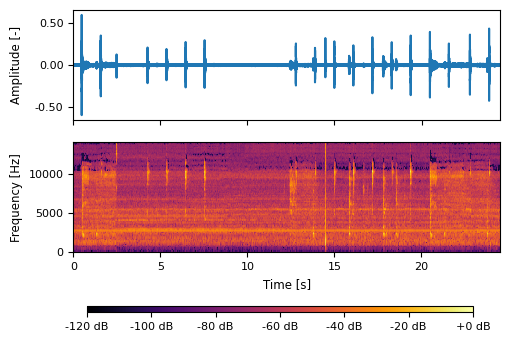

In [11]:
# plot the waveform and mel-scaled spectrogram of an audio file from the selected dataset

file_id_num = 20 # selected file ID number

if file_id_num < len(audio_files_sorted):
    audio_file_path = os.path.join(audio_dataset_dir_path, audio_files_sorted[file_id_num])
    signal, time, D_mel, D_mel_dB = processAudio.get_mel_spectrogram(audio_file_path, sampling_rate, hop_length, n_mels, f_min, f_max, d_min, d_ref)
    print(f"signal type: {type(signal)}")
    print(f"signal shape: {signal.shape}")
    print(f"D_mel_dB_shape: {D_mel_dB.shape}")
    print(f"max D_mel: {np.max(D_mel)}")
    print(f"max D_mel_dB: {np.max(D_mel_dB)}")
    spectrogramPlotter.plot_single_wave_and_mel_spectrogram(signal, time, D_mel_dB, top_dB_abs, f_min, f_max, n_mels, sampling_rate)
else:
    print("File ID out of range")

In [12]:
# calculate the indices of the clicks in the audio file with the sampling rate of 32 kHz

click_index_labels = []
for click_time_label in click_time_labels:
    click_time = float(click_time_label) + 0.032 ## added 32 ms to click times because of the padding taht was added to the audio files (1024 samples at 32 kHz = 32 ms)
    click_index = int(click_time * sampling_rate)
    click_index_labels.append(click_index)
print(click_index_labels[:5])

[374784, 440064, 425664, 382464, 348864]


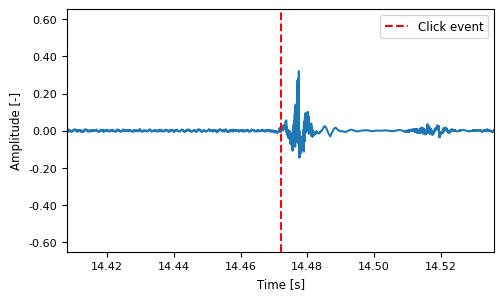

In [ ]:
# plot the signal interval around the peak time of the click event for the same audio file in the selected dataset as the spectrogram plot above

time_interval = (chunk_size/sampling_rate)                  ## this will be the window size in the real time detection --> 4 inputs with 4096 samples each --> with the 32 kHz sampling rate this is 0.512 seconds

peak_time = click_index_labels[file_id_num]/sampling_rate 
interval = time_interval/2                                  ## for setting the x mina and max limits of the plot --> peak time +/- interval

spectrogramPlotter.plot_signal_interval(signal, time, peak_time, interval)

In [15]:
# loading/calculating signals and signal times for the selected dataset

# calculate peak time of the click event for each audio file in the selected dataset
def calc_signal_times(audio_files_sorted, audio_dataset_dir, sampling_rate):
    signals = []            ## audio wave forms
    signal_times = []       ## time stamps in seconds for all samples in an audio file 

    ## load the audio files and calculate the time vector for plotting
    for i in range(len(audio_files_sorted)):
        audio_file_path = os.path.join(audio_dataset_dir, audio_files_sorted[i])
        signal, sampling_rate = librosa.load(audio_file_path, sr=sampling_rate)
        n_samples = len(signal)                         ## number of all samples in the signal
        duration = n_samples / sampling_rate            ## duration of the signal in seconds
        time = np.linspace(0, duration, n_samples)      ## time vector for plotting

        signals.append(signal)                          ## append the signal to the list
        signal_times.append(time)                       ## append the time vector to the list

    return signals, signal_times

## get the signals, signal times
signals, signal_times  = calc_signal_times(audio_files_sorted, audio_dataset_dir_path, sampling_rate)


/var/folders/bj/7ggffpq918g65k1n35l6t6t40000gn/T/ipykernel_46913/2886179812.py:11: UserWarning: PySoundFile failed. Trying audioread instead.
  signal, sampling_rate = librosa.load(audio_file_path, sr=sampling_rate)


In [16]:
# get information about the signals

print("Number of signals: ", len(signals))
print("Number of signal times: ", len(signal_times))
# shape of the signal
print("Shape of the signal: ", signals[1].shape)

Number of signals:  30
Number of signal times:  30
Shape of the signal:  (748160,)


In [5]:
## window sizes and step sizes for dataset generation

window_size = sharedValuesConfig.WINDOW_SIZE    ## 0.512 seconds, corresponds to 4 inputs with 4096 samples each, larger than the click event duration
                                                ## -> 32 columns in the spectrogram

step_size = sharedValuesConfig.STEP_SIZE        ## in this case 8, number of spectrogram columns in one step
                                                ## corresponds 0.128 seconds --> 3/4 overlap

print("Window size: ", window_size)
print("Step size: ", step_size)

Window size:  32
Step size:  8


### 4. Creating spectrogram chunks and labeling them using the manual labels

In [ ]:
# creat datasets similarly as audio inputs are processed during the real-time detection

def createSpectrogramDataset(signals, signal_times, click_index_labels):

    for i in range(len(audio_files_sorted)):

        melspec_full = np.zeros((n_mels, int(samples_per_plot / hop_length)))       ## initialize a mel-scaled spectrogram (equal the size as in real-time detection)
        signal_full = np.zeros(samples_per_plot)                                    ## initialize signal
        time_full = np.zeros(samples_per_plot)                                      ## initialize time
        old_mic_input = np.zeros(chunk_size).astype(np.float32)                     ## initialize old mic input

        detection_window = window_size * hop_length                                 ## number of samples in the detection window
        signal_step_size = step_size * hop_length                                   ## step size in samples

        spec_chunk_dataset = []                                                     ## initialize the dataset
        spec_chunk_labels = []                                                      ## initialize the labels

        audio_file = audio_files_sorted[i]                                          ## get the audio file name
        #print(audio_file)
        signal = signals[i]                                                         ## get the signal
        
        time = signal_times[i]                                                      ## get the time vector
        click_index = click_index_labels[i]                                         ## get the click index
        
        ## iterate over the signal with the step size
        for start_idx in range(0, len(signal) - detection_window, signal_step_size):
            end_idx = start_idx + signal_step_size                                  ## end index of the input
            input_signal_chunk = signal[start_idx:end_idx]                          ## get the input wavefrom
            input_time_chunk = time[start_idx : end_idx]                            ## get the time vector of the input

            new_mic_input = input_signal_chunk                                      ## new microphone input (in real time detection) is the input waveform
            
            ## new input is calculated from the old microphone input and the new microphone input, to replace the edge of the stft window
            mid_mic_signal = np.concatenate((old_mic_input[(chunk_size//2):], new_mic_input[:(chunk_size//2)]))         ## mid microphone signal from the old microphone input and the new microphone input
            mid_signal_time = np.concatenate((input_time_chunk[(chunk_size//2):], input_time_chunk[:(chunk_size//2)]))  ## time vector of the mid microphone signal

            _, _, _, D_mel_dB_new = processAudio.get_mel_spectrogram(new_mic_input, sampling_rate, hop_length, n_mels, f_min, f_max, d_min, d_ref)  ## get the mel-spectrogram of the new microphone input
            _, _, _, D_mel_dB_mid = processAudio.get_mel_spectrogram(mid_mic_signal, sampling_rate, hop_length, n_mels, f_min, f_max, d_min, d_ref) ## get the mel-spectrogram of the mid microphone signal

            new_spectrogram_chunk = np.concatenate((D_mel_dB_mid[:, 4:5], D_mel_dB_new[:, 1:8]), axis=1)        ## new spectrogram chunk from the mid spectrogram and the new spectrogram

            new_signal_chunk = np.concatenate((mid_mic_signal[4*hop_length:5*hop_length], new_mic_input[hop_length:8*hop_length]))      ## new signal chunk from the mid signal and the new signal
            new_time_chunk = np.concatenate((mid_signal_time[4*hop_length:5*hop_length], input_time_chunk[hop_length:8*hop_length]))    ## new time chunk from the mid time vector and the new time vector

            melspec_full = np.roll(melspec_full, -new_spectrogram_chunk.shape[1], axis=1)   ## roll the mel-spectrogram to the left
            melspec_full[:, -new_spectrogram_chunk.shape[1]:] = new_spectrogram_chunk       ## add the new spectrogram input to the mel-spectrogram

            signal_full = np.roll(signal_full, -new_signal_chunk.shape[0])                  ## roll the signal to the left
            signal_full[-new_signal_chunk.shape[0]:] = new_signal_chunk                     ## add the new signal input to the signal

            time_full = np.roll(time_full, -new_time_chunk.shape[0])                        ## roll the time vector to the left
            time_full[-new_time_chunk.shape[0]:] = new_time_chunk                           ## add the new time vector input to the time vector

        
            ## check if the click event is in the detection window, if yes, set the label to 1, otherwise to 0
            if end_idx-detection_window-hop_length < click_index < end_idx-hop_length:
                label = 1
            else:
                label = 0

            ## create spectrogram chunks -> spectrogram_chunk is the investigated area in the real-time detection
            spectrogram_chunk = melspec_full[:, -window_size:]
            signal_chunk = signal_full[-window_size*hop_length:]
            time_chunk = time_full[-window_size*hop_length:]

            spec_chunk_dataset.append(spectrogram_chunk)    ## append the spectrogram chunk to the dataset
            spec_chunk_labels.append(label)                 ## append the label to the labels

            old_mic_input = new_mic_input

        ## save the datasets for each audio file individually
        ## split audio file name and extension
        filename = os.path.splitext(audio_file)[0] + "_dataset.npz"
        save_directory_path = audio_dataset_dir_path
        file_fullpath = os.path.join(save_directory_path, filename)

        ## create array and remove the first 3 chunks and labels as these include the initial zero signal
        spec_chunk_dataset_arr = np.array(spec_chunk_dataset)[3:]
        spec_chunk_labels_arr = np.array(spec_chunk_labels)[3:]

        np.savez(file_fullpath, spec_chunks=spec_chunk_dataset_arr, labels=spec_chunk_labels_arr)

    ## return spec_chunk_dataset, spec_chunk_labels

createSpectrogramDataset(signals, signal_times, click_index_labels)

In [ ]:
# list the saved datasets

saved_datasets = [f for f in os.listdir(audio_dataset_dir_path) if f.endswith('.npz')]
saved_datasets_sorted = sorted(saved_datasets, key=sort_key_func)
print(saved_datasets_sorted[:5])
print(len(saved_datasets_sorted))

['ethernet_test_1_dataset.npz', 'ethernet_test_2_dataset.npz', 'ethernet_test_3_dataset.npz', 'ethernet_test_4_dataset.npz', 'ethernet_test_5_dataset.npz']
30


In [20]:
# load a saved .npz file and get information about the loaded dataset

dataset_to_load_id = 0

dataset_file_path = os.path.join(audio_dataset_dir_path, saved_datasets_sorted[dataset_to_load_id])
dataset = np.load(dataset_file_path)
loaded_spec_chunks = dataset['spec_chunks']     ## loaded spectrogram chunks
loaded_labels = dataset['labels']               ## loaded labels
print(loaded_spec_chunks[0].shape)
print(len(loaded_spec_chunks))
print(len(loaded_labels))

## count the number of positive labels in numpy array
print(np.count_nonzero(loaded_labels == 1))

## indices containing chunks with positive labels
print([i for i, x in enumerate(loaded_labels) if x == 1][:6])

(128, 32)
159
159
4
[88, 89, 90, 91]


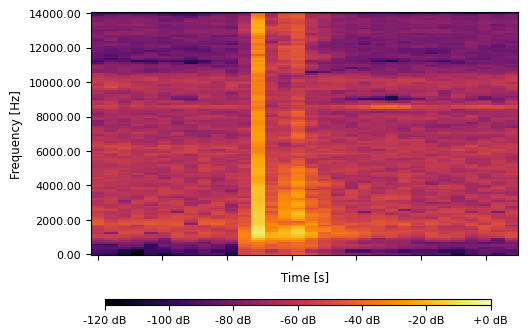

In [26]:
# plot one spectrogram chunk in the loaded dataset
chunk_to_plot_id = 90
spectrogramPlotter.plot_single_mel_spectrogram(loaded_spec_chunks[chunk_to_plot_id], top_dB_abs, f_min, f_max, n_mels)